# Viewing STIS NUV Data
## 0. Collect the following data from the MAST Archive: ODGXT9010
Make sure to collect the calibrated data

## 1. Import the necessary libraries:

In [1]:
# Import for: Reading in fits file
from astropy.table import Table
from astropy.io import fits

# Import for: Downloading necessary files. (Not necessary if you choose to collect data from MAST)
from astroquery.mast import Observations

# Import for: Plotting and specifying plotting parameters
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (20,7)
plt.style.use("bmh")

import numpy as np

## 2. Reading in the data

### 2.1 Investigating the Data - Basics
Before doing any operation on the data, we want to first explore the basics and data file structures.

The Aperture extracted, background subtracted, flux and wavelength calibrated spectra data is stored in fits file with suffix x1d. Open the x1d fits file and explore its info and header.

In [2]:
#NUV
#first read the x1d fits file as a hdu list
x1d_file="./Data/NUV/ODGXT9010/ODGXT9010_x1d.fits"
x1d_hdul = fits.open(x1d_file)

In [3]:
#get information about the fits file
x1d_hdul.info()

Filename: ./Data/NUV/ODGXT9010/ODGXT9010_x1d.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     278   ()      
  1  SCI           1 BinTableHDU    156   1R x 19C   [1I, 1I, 1024D, 1024E, 1024E, 1024E, 1024E, 1024E, 1024E, 1024I, 1E, 1E, 1I, 1E, 1E, 1E, 1E, 1024E, 1E]   


In [4]:
fits.getheader(x1d_file,0)

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                   16 / number of bits per data pixel                  
NAXIS   =                    0 / number of data axes                            
EXTEND  =                    T / FITS file may contain extensions               
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
ORIGIN  = 'HSTIO/CFITSIO March 2010' / FITS file originator                     
DATE    = '2022-04-16' / date this file was written (yyyy-mm-dd)                
NEXTEND =                    1 / Number of extensions                           
FILENAME= 'odgxt9010_x1d.fits' / name of file                                   
FILETYPE= 'SCI      '          / type of data found in data file                
                                                                                
TELESCOP= 'HST'             

In [5]:
#get data
x1d_data = Table.read(x1d_file,1)
x1d_data

SPORDER,NELEM,WAVELENGTH [1024],GROSS [1024],BACKGROUND [1024],NET [1024],FLUX [1024],ERROR [1024],NET_ERROR [1024],DQ [1024],A2CENTER,EXTRSIZE,MAXSRCH,BK1SIZE,BK2SIZE,BK1OFFST,BK2OFFST,EXTRLOCY [1024],OFFSET
,,Angstroms,Counts/s,Counts/s,Counts/s,erg / (Angstrom cm2 s),erg / (Angstrom cm2 s),Counts/s,,pix,pix,pix,pix,pix,pix,pix,pix,pix
int16,int16,float64,float32,float32,float32,float32,float32,float32,int16,float32,float32,int16,float32,float32,float32,float32,float32,float32
1,1024,3010.507864169737 .. 3098.557379270491,0.005990227 .. 0.004368662,0.0008788652 .. 0.00641084,0.005111361 .. -0.002042178,2.293795e-15 .. -1.412028e-15,2.211159e-15 .. 1.512657e-15,0.00492722 .. 0.002187716,2580 .. 2564,507.9059,11,1024,5,5,-300,300,520.0425 .. 498.8784,486.687


## 3. Plotting the data
### 3.1 Make a simple plot of the spectrum we just collected and read.

Text(0, 0.5, 'Flux [ergs/s/cm$^2$/$\\AA$]')

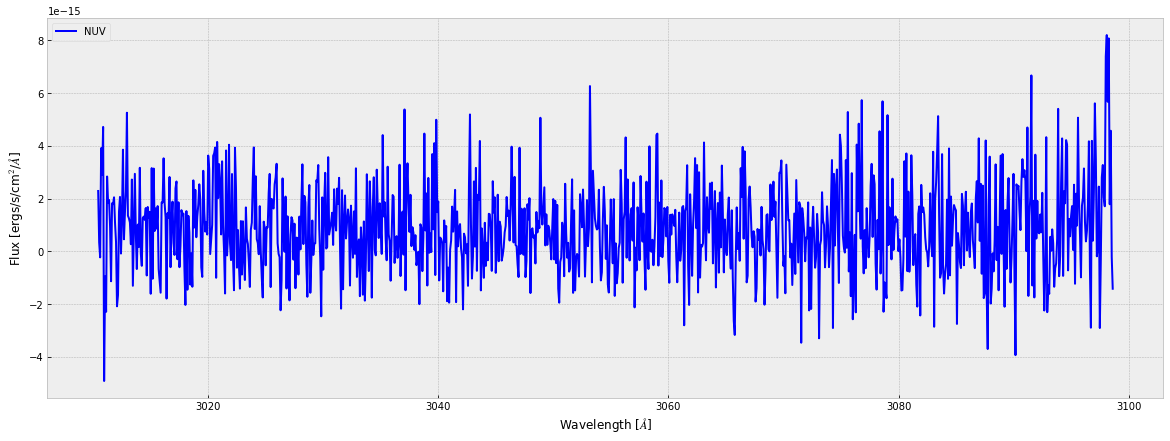

In [6]:
wl = x1d_data["WAVELENGTH"].flatten()
flux = x1d_data["FLUX"].flatten()
order = np.argsort(wl)
wl = np.array(wl)[order]
flux = np.array(flux)[order]
plt.plot(wl, flux, color="blue", label="NUV")
plt.legend(loc="best")
plt.xlabel("Wavelength [$\AA$]")
plt.ylabel("Flux [ergs/s/cm$^2$/$\AA$]")

### 3.2 Make a more complex plot to examine the spectrum in detail.
In this case, we segment the entire spectrum into 5 parts so that we can have a closer look at the flux of each wavelength.

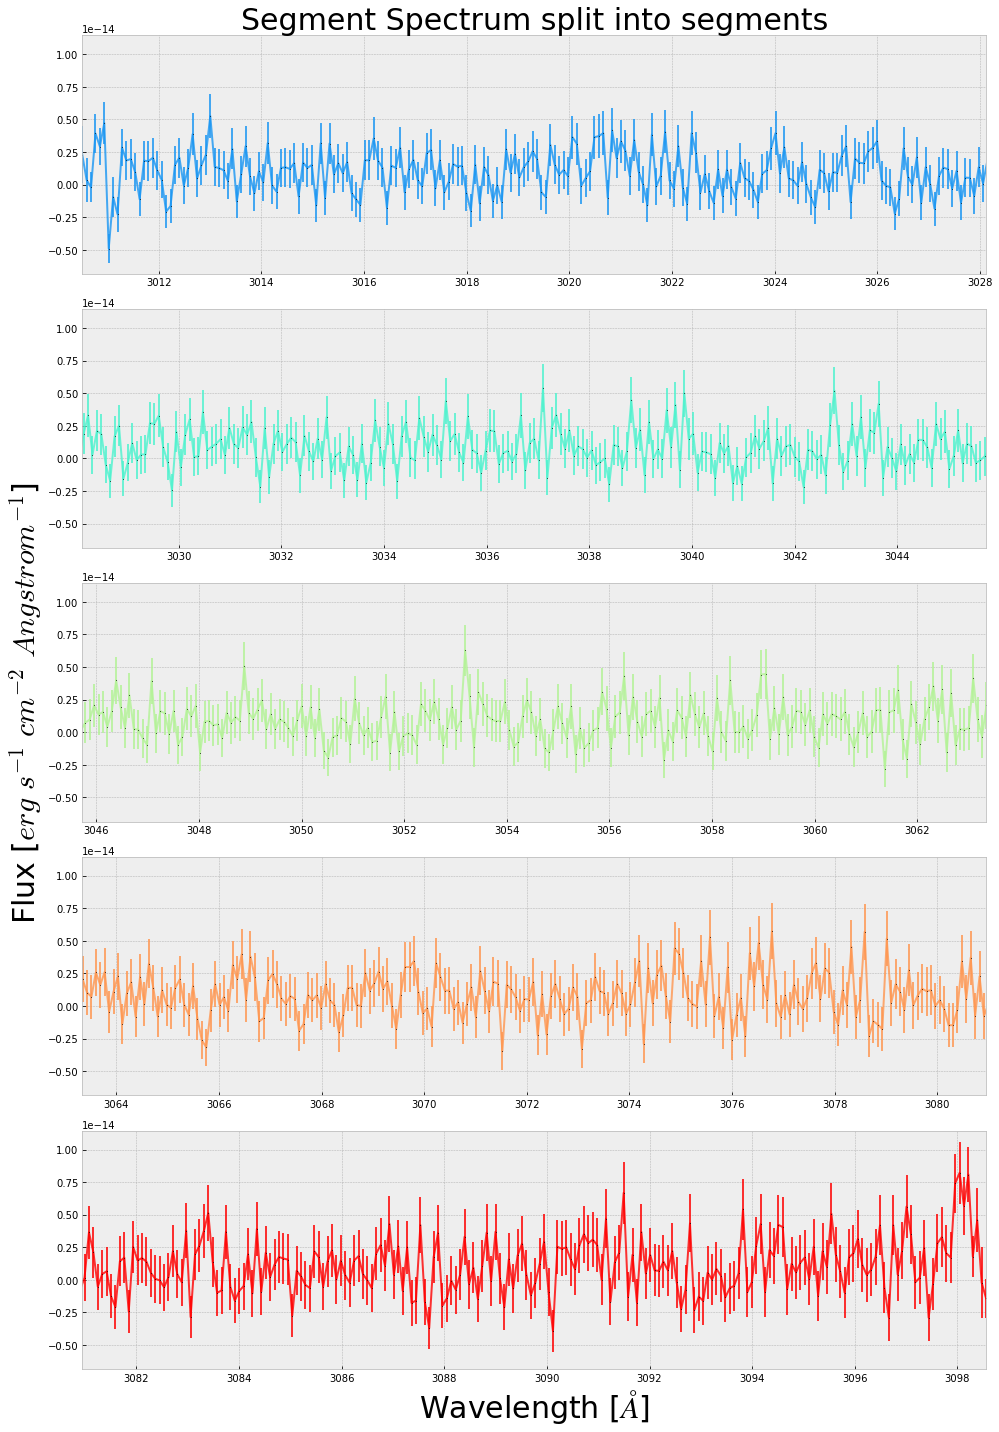

In [7]:
for segment_row in x1d_data:  # Apply the following to each segment's data at a time
    # Selects all immediately useful data for the chosen segment
    wvln= segment_row["WAVELENGTH"]
    flux= segment_row["FLUX"]
    fluxErr = segment_row["ERROR"]
    minx, maxx = min(wvln), max(wvln)
    miny, maxy = min(flux), max(flux)
    rangex = maxx - minx
    fig = plt.figure(figsize=(14, 20))

    nRows = 5  # How many segments we wish to split the spectrum into

    for i in range(nRows):
        min_ = minx + i*rangex/nRows
        max_ = minx + (i+1)*rangex/nRows
        ax = plt.subplot(nRows, 1, i+1)

        if i == 0:  # A way to set Title, xlabel, and ylabel that will work independent of number of rows
            ax.set_title(
                f"Segment Spectrum split into segments", size=30)
        if i == nRows - 1:
            ax.set_xlabel("Wavelength [$\AA$]", size=30)
        if i == int(nRows/2):
            ax.set_ylabel(
                'Flux [$erg\ s^{-1}\ cm^{-2}\ Angstrom^{-1}$]', size=30)

        # Create the plot itself
        ax.errorbar(wvln, flux, fluxErr, c=plt.cm.rainbow((i+1)/nRows), alpha=0.8,
                    marker='.', markerfacecolor='k', markersize=2, mew=0)

        ax.set_xlim(min_, max_)
    plt.tight_layout()
    plt.show()

## 4.Data Quality
### 4.1 Data Quality Frequencies Histogram
Make a histogram according to the data quality flags, and label the bins by what each data quality values actually means.
More info: https://hst-docs.stsci.edu/stisdhb/chapter-2-stis-data-structure/2-5-error-and-data-quality-array

In [9]:
#First get the data quality flag from the x1d fits file, and convert them to log2 values
#The data quality flag is a masked array that "hides" the pixels with no data quality issue. 
#We fill those "good points" with -1 in our case
log_DQ = np.log2(x1d_data[0]["DQ"]).filled(-1)
log_DQ = log_DQ.astype(int)

/Users/kding/miniconda3/envs/stis/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log2
  after removing the cwd from sys.path.


In [10]:
#First get the data quality flag from the x1d fits file, and convert them to log2 values
#The data quality flag is a masked array that "hides" the pixels with no data quality issue. 
#We fill those "good points" with -1 in our case
x1d_dq = x1d_data[0]["DQ"].filled(0)
dq_bits = []
for dq in x1d_dq:
    if dq == 0:
        dq_bits.append(-1)
    else:
        for b in range(0,15):
            if dq & (2**b):
                dq_bits.append(b)

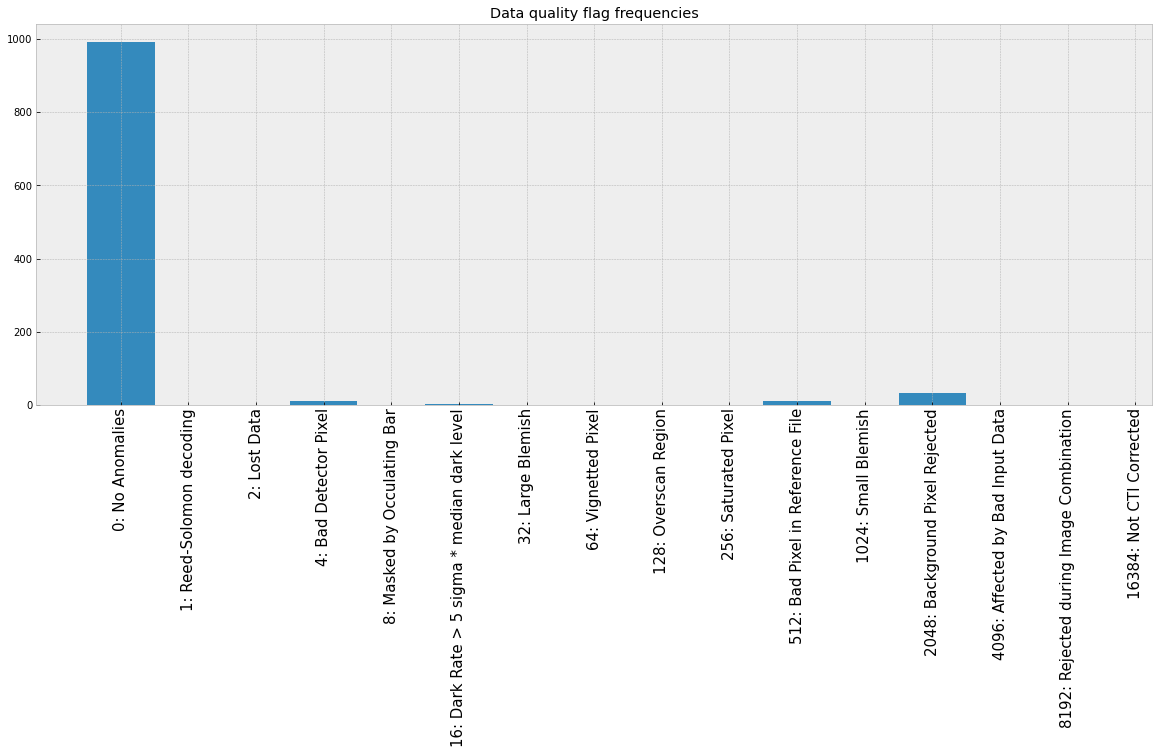

In [11]:
#Assign the meaning of each data quality and make the histogram
meanings = ["No Anomalies","Reed-Solomon decoding","Lost Data","Bad Detector Pixel","Masked by Occulating Bar",
           "Dark Rate > 5 sigma * median dark level","Large Blemish","Vignetted Pixel","Overscan Region",
            "Saturated Pixel","Bad Pixel in Reference File","Small Blemish","Background Pixel Rejected",
           "Affected by Bad Input Data","Rejected during Image Combination","Not CTI Corrected"]
for i in range(len(meanings)):
    meanings[i] = str(int(2**(i-1)))+": "+meanings[i]

bins_ = np.arange(-1, 15)
plt.title("Data quality flag frequencies")
h = plt.hist(dq_bits,bins=bins_)
x = plt.xticks(bins_+0.5, labels=meanings, rotation='vertical', fontsize=15)

### 4.2 Removing "Serious Data Quality"
Through the calibaration pipeline, some data qualities are marked "serious". The value of serious data qualities are marked through "SDQFLAGS". We can decompose that value according to the bits in order to see the specific data quality flags that are marked serious.

In [13]:
sdqFlags_fuv=fits.getheader(x1d_file,1)["SDQFLAGS"]
sdq=[]
print(
    f"The FUV was processed with SDQFLAGS = {sdqFlags_fuv}, which in binary is {bin(sdqFlags_fuv)[2:]}")
print("\t\tThus, the following DQ-flagged data get weighted by 0:\n")
for i, char in enumerate(bin(sdqFlags_fuv)[2:]):
    if char == '1':
        if 2**(i+1) not in sdq:
            sdq.append(2**(i))
        print(f"\t\t\t", meanings[i+1])

The FUV was processed with SDQFLAGS = 31743, which in binary is 111101111111111
		Thus, the following DQ-flagged data get weighted by 0:

			 1: Reed-Solomon decoding
			 2: Lost Data
			 4: Bad Detector Pixel
			 8: Masked by Occulating Bar
			 32: Large Blemish
			 64: Vignetted Pixel
			 128: Overscan Region
			 256: Saturated Pixel
			 512: Bad Pixel in Reference File
			 1024: Small Blemish
			 2048: Background Pixel Rejected
			 4096: Affected by Bad Input Data
			 8192: Rejected during Image Combination
			 16384: Not CTI Corrected


Text(0, 0.5, 'Flux [$erg\\ s^{-1}\\ cm^{-2}\\ Angstrom^{-1}$]')

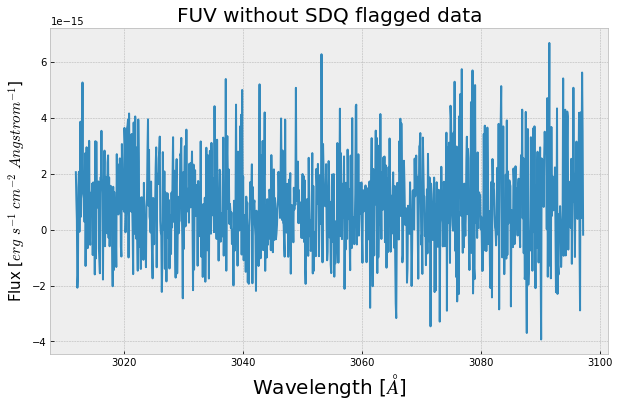

In [14]:
# Filter the datapoints to where there are no serious DQ flags
mask_noSDQ = np.ones(len(x1d_data[0]["WAVELENGTH"]),dtype=bool)
for i in range(0,len(x1d_data[0]["WAVELENGTH"])):
    for dq in sdq:
        if x1d_data[0]["DQ"][i] & dq:
            mask_noSDQ[i]=False
            break
wvln_noSDQ, flux_noSDQ = x1d_data[0]["WAVELENGTH"][
    mask_noSDQ], x1d_data[0]["FLUX"][mask_noSDQ]

# Make the figure:
plt.figure(figsize=(10, 6))

# Plot the filtered datapoints
plt.plot(wvln_noSDQ, flux_noSDQ)

# Format the figure
plt.title("FUV without SDQ flagged data", size=20)
plt.xlabel('Wavelength [$\AA$]', size=20)
plt.ylabel('Flux [$erg\ s^{-1}\ cm^{-2}\ Angstrom^{-1}$]', size=15)

## 5. STIS NUV Image
### 5.1 Explore image file structure
The rectified, wavelength and flux calibrated first order spectra or Geometrically corrected imaging data is stored in the fits file with the flt extension. Similar to what we did to the x1d file, we first open the fits file to explore its file structure.

In [15]:
#read in the x2d file and get its info
flt_file="./Data/NUV/ODGXT9010/ODGXT9010_flt.fits"
fits.info(flt_file)

Filename: ./Data/NUV/ODGXT9010/ODGXT9010_flt.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     242   ()      
  1  SCI           1 ImageHDU       120   (1024, 1024)   float32   
  2  ERR           1 ImageHDU        61   (1024, 1024)   float32   
  3  DQ            1 ImageHDU        44   (1024, 1024)   int16   


- The first, of extension type SCI, stores the science values.
- The second, of extension type ERR, contains the statistical errors, which are propagated through the calibration process. It is unpopulated in raw data files.
- The third, of extension type DQ, stores the data quality values, which flag suspect pixels in the corresponding SCI data. It is unpopulated in raw data files.

Similarly, we can also get the header from this fits file to see the scientific metadata.

In [16]:
fits.getheader(flt_file,0)

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                   16 / number of bits per data pixel                  
NAXIS   =                    0 / number of data axes                            
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
ORIGIN  = 'HSTIO/CFITSIO March 2010' / FITS file originator                     
DATE    = '2022-04-16' / date this file was written (yyyy-mm-dd)                
NEXTEND =                    3 / Number of standard extensions                  
FILENAME= 'odgxt9010_flt.fits' / name of file                                   
FILETYPE= 'SCI      '          / type of data found in data file                
                                                                                
TELESCOP= 'HST'             

### 5.2 Show the image
Now we collect the science image data from the fits file and show the image.

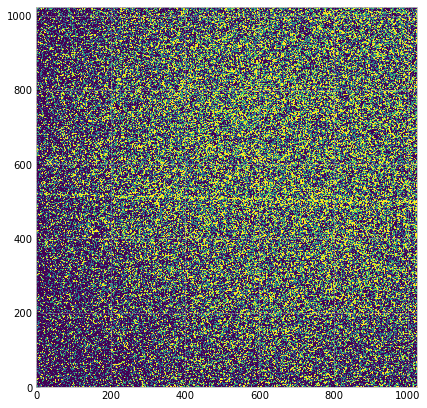

In [18]:
flt_data=fits.open(flt_file)[1].data
plt.imshow(flt_data,origin='lower',vmin=0,vmax=1,cmap="viridis")